<a href="https://www.kaggle.com/code/minhjuniordinh/machine-learning-review-2?scriptVersionId=294341346" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
For context, this code was my submission for an Assignment 2 of the unit FIT5201 Machine Learning from Monash University.

Here, I learnt EM algorithm used to find the maximum likelihood, decision boundaries in neural networks (NN) and self-supervised NN learning (learning from unlabelled data).

# Question 1 [Expectation Maximisation]

## Part I


Please briefly answer the following high-level questions:
– Write mathematical formulations of the optimization functions of maximum likelihood
estimation (MLE) for the document clustering model with complete data and incomplete
data, respectively. Then briefly describe why MLE with incomplete data is hard to
optimize.
– Briefly explain the high-level idea of the EM algorithm to find MLE parameter estimates.

### Document Clustering with EM

#### 1. Complete Data Likelihood (When Cluster Assignments $Z$ Are Known)

**Equation:**
$$
\ln p(\mathbf{X}, \mathbf{Z}|\theta) = \sum_{n=1}^N \sum_{k=1}^K z_{nk} \left( \ln \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \ln \mu_{k,w} \right)
$$

**Calculates:**  
Total probability of both documents **and their true cluster assignments** given the model parameters.

**Parameters/Symbols:**
- $\mathbf{X} = \{d_1, ..., d_N\}$: All documents (observed data)
- $\mathbf{Z} = \{z_1, ..., z_N\}$: Cluster assignments (latent variables)
  - $z_{nk}$: Binary indicator (1 if document $n$ belongs to cluster $k$, else 0)
- $\theta = (\varphi, \mu)$: Model parameters
  - $\varphi_k$: Prior probability of cluster $k$ (must sum to 1)
  - $\mu_{k,w}$: Probability of word $w$ in cluster $k$'s vocabulary distribution
- $\mathcal{A}$: Vocabulary (all unique words)
- $c(w, d_n)$: Count of word $w$ in document $d_n$

**How it works:**
1. For each document ($n$) and cluster ($k$):
   - If $d_n$ is in cluster $k$ ($z_{nk}=1$ - it belongs to cluster), add:
     - $\ln \varphi_k$: Log-probability of choosing cluster $k$
     - $\sum_w c(w, d_n) \ln \mu_{k,w}$: Log-probability of generating document's words from cluster $k$'s word distribution
2. Sum over all documents and clusters.

---

#### 2. Incomplete Data Likelihood (Real Case - Cluster Assignments $Z$ Unknown)

**Equation:**
$$
\ln p(\mathbf{X}|\theta) = \sum_{n=1}^N \ln \left( \sum_{k=1}^K \varphi_k \prod_{w \in \mathcal{A}} \mu_{k,w}^{c(w, d_n)} \right)
$$

**Calculates:**  
Marginal probability of **just the documents** (summing over all possible cluster assignments).

**Why Hard to Optimize?**
1. **Log-Sum Problem**: The $\ln \sum_k$ makes derivatives non-linear.
2. **No Closed Form**: Cannot solve for $\theta$ directly because cluster assignments are unknown.
3. **Exponential Complexity**: For $K$ clusters and $N$ docs, there are $K^N$ possible assignments to sum over.

---

#### 3. EM Algorithm - Step-by-Step

**Key Idea:** Iteratively refine estimates using "soft" cluster assignments.

##### E-Step: Compute Responsibilities
**Equation:**
$$
\gamma(z_{nk}) = \frac{\varphi_k \prod_{w} \mu_{k,w}^{c(w,d_n)}}{\sum_{j=1}^K \varphi_j \prod_{w} \mu_{j,w}^{c(w,d_n)}}
$$

**Calculates:**  
The probability that document $d_n$ belongs to cluster $k$ given current parameters.
- Numerator: Probability of $d_n$ under cluster $k$
- Denominator: Normalizes to make $\gamma(z_{nk})$ a valid probability (sums to 1 across clusters)

##### M-Step: Update Parameters
**Cluster Proportions:**
$$
\varphi_k = \frac{N_k}{N}, \quad \text{where } N_k = \sum_{n=1}^N \gamma(z_{nk})
$$
- **Meaning**: New $\varphi_k$ is the fraction of documents "softly" assigned to cluster $k$.

**Word Distributions:**
$$
\mu_{k,w} = \frac{\sum_{n=1}^N \gamma(z_{nk}) c(w, d_n)}{\sum_{w'} \sum_{n=1}^N \gamma(z_{nk}) c(w', d_n)}
$$
- **Meaning**: Re-estimates $\mu_{k,w}$ as the weighted average of word counts in documents, where weights are cluster responsibilities.

**Why EM Works:**
1. **E-Step**: "Guesses" cluster assignments probabilistically.
2. **M-Step**: Treats these guesses as "pseudo-data" to update parameters.
3. **Convergence**: Each iteration increases the likelihood (guaranteed to improve).

## Part II


Derive Expectation and Maximization steps of the (soft)-EM algorithm for Document Clustering, in a markdown cell (ideally using Latex for clean typesetting and show your work in
your submitted PDF report.) In particular, include all model parameters that should be
learnt and the exact expression (using the same math convention that we saw in the Module
4) that should be used to update these parameters during the learning process (ie., E-step,
M-step and assignments).


## Model Definition and Parameters

**Observed Data & Setup:**
* **Documents ($\mathbf{X}$)**: A collection of $N$ documents, $\mathbf{X} = \{d_1, \dots, d_N\}$.
* **Vocabulary ($\mathcal{A}$)**: The set of all unique words.
* **Word Counts ($c(w, d_n)$)**: Count of word $w \in \mathcal{A}$ in document $d_n$.

**Latent Variables ($\mathbf{Z}$):**
* $z_{nk}$: Binary indicator; $z_{nk}=1$ if document $d_n$ belongs to cluster $k$, else $0$. $\sum_{k=1}^K z_{nk} = 1$.

**Model Parameters ($\theta$) to be Learned:**
1. **Mixture Weights ($\varphi_k$)**: Prior probability of cluster $k$.
   $$\varphi_k = p(z_{nk}=1)$$
   Constraint: $\varphi_k \ge 0$, $\sum_{k=1}^K \varphi_k = 1$.

2. **Word Probabilities ($\mu_{k,w}$)**: Probability of word $w$ given cluster $k$.
   $$\mu_{k,w} = p(w \mid \text{cluster } k)$$
   Constraint: $\mu_{k,w} \ge 0$, $\sum_{w \in \mathcal{A}} \mu_{k,w} = 1$ for each $k$.

**Likelihoods:**
- Probability of $d_n$ given cluster $k$:
  $$p(d_n \mid z_{nk}=1, \mathbf{\mu}_k) = \prod_{w \in \mathcal{A}} \mu_{k,w}^{c(w,d_n)}$$

- Joint probability of $d_n$ and assignment to cluster $k$:
  $$p(d_n, z_{nk}=1 \mid \theta) = \varphi_k \prod_{w \in \mathcal{A}} \mu_{k,w}^{c(w,d_n)}$$

**Complete-Data Log-Likelihood** (if $\mathbf{Z}$ were known):
$$\ln p(\mathbf{X}, \mathbf{Z} | \theta) = \sum_{n=1}^N \sum_{k=1}^K z_{nk} \left( \ln \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \ln \mu_{k,w} \right)$$

---
## Expectation Step (E-Step)

The E-step computes the responsibility $\gamma(z_{nk})$, which is the posterior probability $p(z_{nk}=1 | d_n, \theta^{\text{old}})$ given current parameters $\theta^{\text{old}} = (\varphi^{\text{old}}, \mu^{\text{old}})$.

Using Bayes' theorem:
$$\gamma(z_{nk}) = \frac{p(d_n | z_{nk}=1, \theta^{\text{old}}) p(z_{nk}=1 | \theta^{\text{old}})}{\sum_{j=1}^K p(d_n | z_{nj}=1, \theta^{\text{old}}) p(z_{nj}=1 | \theta^{\text{old}})}$$
Substituting model definitions: $$p(z_{nk}=1 | \theta^{\text{old}}) = \varphi_k^{\text{old}}$$

$$and$$

$$p(d_n | z_{nk}=1, \theta^{\text{old}}) = \prod_{w \in \mathcal{A}} (\mu_{k,w}^{\text{old}})^{c(w,d_n)}$$

We get:

$$\boxed{ \gamma(z_{nk}) = \frac{\varphi_k^{\text{old}} \prod_{w \in \mathcal{A}} (\mu_{k,w}^{\text{old}})^{c(w,d_n)}}{\sum_{j=1}^K \varphi_j^{\text{old}} \prod_{w \in \mathcal{A}} (\mu_{j,w}^{\text{old}})^{c(w,d_n)}} }$$
Note: $\sum_{k=1}^K \gamma(z_{nk}) = 1$ for each document $n$.

---
## Maximization Step (M-Step)

The M-step updates parameters $\theta^{\text{new}} = (\varphi^{\text{new}}, \mu^{\text{new}})$ by maximizing the expected complete-data log-likelihood ($Q$-function) using responsibilities $\gamma(z_{nk})$ from the E-step:
$$Q(\theta | \theta^{\text{old}}) = \sum_{n=1}^N \sum_{k=1}^K \gamma(z_{nk}) \left( \ln \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \ln \mu_{k,w} \right)$$

**1. Update Mixture Weights ($\varphi_k^{\text{new}}$):**

Maximize $Q$ w.r.t. $\varphi_k$ subject to $\sum_{k=1}^K \varphi_k = 1$. The Lagrangian is:
$$
\mathcal{L}(\varphi, \lambda) = \sum_n \sum_k \gamma(z_{nk}) \ln \varphi_k + \lambda \left(1 - \sum_k \varphi_k\right).
$$

Setting $\frac{\partial \mathcal{L}}{\partial \varphi_k} = 0$ gives:
$$
\varphi_k = \frac{\sum_n \gamma(z_{nk})}{\lambda}.
$$

Applying $\sum_k \varphi_k = 1$, we find $\lambda = \sum_k \sum_n \gamma(z_{nk}) = N$ (total number of documents). The update is:
$$
\boxed{ \varphi_k^{\text{new}} = \frac{\sum_{n=1}^N \gamma(z_{nk})}{N} }
$$

---

**2. Update Word Probabilities ($\mu_{k,w}^{\text{new}}$):**

Maximize $Q$ w.r.t. $\mu_{k,w}$ for each cluster $k$, subject to $\sum_{w \in \mathcal{A}} \mu_{k,w} = 1$. The Lagrangian for cluster $k$ is:
$$
\mathcal{L}(\mathbf{\mu}_k, \beta_k) = \sum_n \gamma(z_{nk}) \sum_w c(w, d_n) \ln \mu_{k,w} + \beta_k \left(1 - \sum_w \mu_{k,w}\right).
$$

Setting $\frac{\partial \mathcal{L}}{\partial \mu_{k,w}} = 0$ gives:
$$
\mu_{k,w} = \frac{\sum_n \gamma(z_{nk}) c(w, d_n)}{\beta_k}.
$$

Applying $\sum_w \mu_{k,w} = 1$, we find:
$$
\beta_k = \sum_{w' \in \mathcal{A}} \sum_{n=1}^N \gamma(z_{nk}) c(w', d_n).
$$

The update is:
$$
\boxed{ \mu_{k,w}^{\text{new}} = \frac{\sum_{n=1}^N \gamma(z_{nk}) c(w, d_n)}{\sum_{w' \in \mathcal{A}} \sum_{n=1}^N \gamma(z_{nk}) c(w', d_n)} }
$$

---
## Document Assignments (After Convergence)

After convergence, assign document $d_n$ to the cluster $k^*$ with the highest responsibility (probability):
$$\text{cluster}(d_n) = k^* = \arg\max_k \gamma(z_{nk})$$

---

## Part III

Load Task2A.txt file (if needed, perform text preprocessing similar to what we did in Activity
4.2).

In [1]:
# Part III: Load and preprocess data
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer  # converting text to word count vectors
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer  # For normalising vectors
from sklearn.feature_extraction.text import TfidfTransformer  # For TF-IDF transformations

file_path = '/kaggle/input/a2-dataset/A2_dataset/Task2A.txt'
raw_lines = []

with open(file_path, 'r', encoding='utf-8', errors='ignore') as fh:
    # Read each line, strip whitespace, and keep only non-empty lines
    raw_lines = [ln.strip() for ln in fh if ln.strip()]

labels, articles = [], []

for ln in raw_lines:
    # Split each line at first tab character (max 1 split)
    parts = ln.split('\t', 1)

    # Check if line contains both label and text (separated by tab)
    if len(parts) == 2:  # labelled data
        lbl, txt = parts
    else:  # unlabelled data (no tab found)
        lbl, txt = 'UNK', parts[0]  # default label 'UNK' for unlabelled data

    # Append to lists
    labels.append(lbl)
    articles.append(txt)

# Create a pandas DataFrame to store the labeled documents
docs_df = pd.DataFrame({'label': labels, 'article': articles})

# Convert label column to categorical type
docs_df.label = docs_df.label.astype('category')

print(f'Loaded {len(docs_df):,} documents   ( {docs_df.label.nunique()} unique labels )')
display(docs_df.head(3))

# For clustering, we will use just the articles (raw_docs)
docs = docs_df['article'].tolist()

Loaded 2,373 documents   ( 4 unique labels )


,label,article
0,sci.crypt,ripem frequently asked questions archive name ...
1,sci.crypt,ripem frequently asked questions archive name ...
2,sci.crypt,ripem frequently noted vulnerabilities archive...


## Part IV

Implement the EM algorithm (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.

**Hint: a):** If it helps, feel free to base your code on the provided code for EM algorithm for GMM in Activity 4.1. However, please remember that the EM algorithm is not limited to solving GMMs; based on the lecture, make sure to assess and choose the appropriate model that fits your specific needs. **b):** When implementing the M-step, you will need to normalize the posterior probability matrix in a row-wise manner. Formally, if we need to normalize an $N$ dimensional vector of log probabilities $x_i = \log p_i$ using Softmax, we might naively compute the following equation
$$
p_i = \frac{\exp(x_i)}{\sum_{n=1}^{N} \exp(x_n)}, \quad \sum_{n=1}^{N} p_n = 1 \quad (1)
$$

Since each $x_i$ is a log probability which may be very large, and either negative or positive, then exponentiating might result in under- or overflow respectively. For example, $\exp(10000) = \inf$. We can simply use the log-sum-exp trick to avoid this numerical unstability. We consider the log-sum-exp operation:
$$
\text{LSE}(x_1, \dots, x_N) = \log \left( \sum_{n=1}^{N} \exp(x_n) \right), \quad (2)
$$
$$
= c + \log \left( \sum_{n=1}^{N} \exp(x_n - c) \right), \quad (3)
$$
where we usually set $c = \max\{x_1, \dots, x_N\}$ to ensure that the largest positive exponentiated term is $\exp(0) = 1$, so you will definitely not overflow, and even if you underflow, the answer will be sensible. Then the final equation will be
$$
p_i = \exp \left( x_i - c - \log \left( \sum_{n=1}^{N} \exp(x_n - c) \right) \right). \quad (4)
$$

**You should use this log-sum-exp trick during implementation.**

In [2]:
def logsumexp(log_probs, axis=1, keepdims=True):
    """
    Compute log(sum(exp(log_probs))) in a numerically stable way.
    Implements the log-sum-exp trick to avoid numerical overflow/underflow.

    Args:
        log_probs: Array of log probabilities
        axis: Axis along which to compute the sum
        keepdims: Whether to keep the original dimensions
    Returns:
        log(sum(exp(log_probs))) computed in a numerically stable way
    """
    max_log = np.max(log_probs, axis=axis, keepdims=True)  # Find max along axis for stability
    return max_log + np.log(np.sum(np.exp(log_probs - max_log), axis=axis, keepdims=True))

def softmax_log(log_A: np.ndarray) -> np.ndarray:
    """
    Numerically stable row-wise softmax for log-probabilities.
    Converts log probabilities to probabilities using stable softmax.

    Args:
        log_A: (N, K) matrix of log probabilities
    Returns:
        (N, K) matrix of probabilities where each row sums to 1
    """
    # log_A: (N, K)
    log_Z = logsumexp(log_A, axis=1, keepdims=True)  # (N,1) Compute normalizing constant
    return np.exp(log_A - log_Z)  # (N,K) Apply softmax normalization

class _BaseMultinomial:
    """
    Base class for multinomial mixture models (EM, Hard-EM).
    Implements common functionality for both soft and hard EM variants.
    """
    def __init__(self, n_clusters, max_iter=250, tol=1e-5, alpha=1e-2, min_df=25, random_state=0):
        """
        Initialize the mixture model with hyperparameters.

        Args:
            n_clusters: Number of mixture components (K)
            max_iter: Maximum EM iterations
            tol: Convergence tolerance
            alpha: Dirichlet prior parameter (pseudocount)
            min_df: Minimum document frequency for vocabulary
            random_state: Random seed for reproducibility
        """
        self.K = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = alpha  # Smoothing parameter for Dirichlet prior
        self.min_df = min_df  # Minimum document frequency for words
        self.random_state = random_state
        np.random.seed(random_state)  # Set random seed for reproducibility

    def fit(self, raw_docs, verbose=False):
        """
        Fit the model to the given documents using EM algorithm.

        Args:
            raw_docs: List of raw text documents
            verbose: Whether to print progress information
        Returns:
            self: The fitted model
        """
        X = self._vectorise(raw_docs)  # Convert documents to word count matrix
        N, V = X.shape  # N documents, V vocabulary size
        self._init_params(V)  # Initialise model parameters

        log_L_prev = -np.inf  # Initialise previous log-likelihood
        for it in range(self.max_iter):
            gamma = self._e_step(X)    # (N, K) E-step: compute responsibilities
            self._m_step(X, gamma)     # M-step: update parameters beta_, phi_

            # Compute log-likelihood for convergence check
            log_joint = X @ np.log(self.beta_ + 1e-20).T + np.log(self.phi_ + 1e-20)
            log_prob_N = logsumexp(log_joint, axis=1, keepdims=False)  # (N,) log-likelihood per doc
            log_L = np.sum(log_prob_N)  # Total log-likelihood

            if verbose:
                print(f'Iter {it+1:2d}   log-L = {log_L:,.6f}')
            if abs(log_L - log_L_prev) < self.tol:
                if verbose:
                    print('converged!')
                break
            log_L_prev = log_L
        return self

    def predict_proba(self, new_docs):
        """
        Predict cluster probabilities for new documents.

        Args:
            new_docs: List of raw text documents
        Returns:
            (N, K) matrix of cluster probabilities
        """
        X = self.vectoriser_.transform(new_docs).toarray().astype(np.float64)
        return self._posterior(X)

    def predict(self, new_docs):
        """
        Predict cluster assignments for new documents.

        Args:
            new_docs: List of raw text documents
        Returns:
            Array of cluster indices (0..K-1)
        """
        return self.predict_proba(new_docs).argmax(axis=1)

    def _vectorise(self, raw_docs):
        """
        Convert raw documents to word count matrix using CountVectorizer.

        Args:
            raw_docs: List of raw text documents

        Returns:
            Sparse matrix of word counts (N documents x V vocabulary)
        """
        self.vectoriser_ = CountVectorizer(lowercase=True, stop_words='english', min_df=self.min_df)
        return self.vectoriser_.fit_transform(raw_docs).toarray().astype(np.float64)

    def _init_params(self, V):
        """
        Initialize model parameters.

        Args:
            V: Vocabulary size
        """
        self.phi_ = np.full(self.K, 1 / self.K)  # Uniform prior over clusters
        # Dirichlet random initialization of beta, size: (K, V)
        self.beta_ = np.random.dirichlet(np.ones(V), size=self.K)  # Word distributions per cluster

    def _posterior(self, X):
        """
        Compute posterior cluster probabilities for documents.

        Args:
            X: Document-word count matrix (N x V)
        Returns:
            (N, K) matrix of cluster probabilities
        """
        log_joint = X @ np.log(self.beta_ + 1e-20).T + np.log(self.phi_ + 1e-20)  # log p(x,z)
        return softmax_log(log_joint)  # Convert to probabilities p(z|x)

    def _e_step(self, X): ...  # implemented by subclasses
    def _m_step(self, X, gamma): ...  # implemented by subclasses

    def top_words(self, cluster_id, top_n=10):
        """
        Get top words for a cluster by probability.

        Args:
            cluster_id: Cluster index (0..K-1)
            top_n: Number of top words to return
        Returns:
            List of top words for the cluster
        """
        vocab = np.array(self.vectoriser_.get_feature_names_out())
        idx = np.argsort(self.beta_[cluster_id])[::-1][:top_n]  # Indices of top words
        return vocab[idx].tolist()

class MultinomialEM(_BaseMultinomial):
    """
    Soft-EM responsibilities (standard EM) where documents have partial membership in clusters.
    """
    def _e_step(self, X):
        """
        E-step: Compute soft responsibilities (posterior probabilities).

        Args:
            X: Document-word count matrix (N x V)
        Returns:
            (N, K) matrix of responsibilities (cluster probabilities)
        """
        return self._posterior(X)  # (N, K) Standard soft EM uses full posterior

    def _m_step(self, X, gamma):
        """
        M-step: Update parameters using current responsibilities.

        Args:
            X: Document-word count matrix (N documents x V vocabulary terms)
            gamma: matrix (N documents, K clusters) responsibility matrix
        """
        N_k = gamma.sum(axis=0)  # (K,) Effective number of docs per cluster
        self.phi_ = N_k / N_k.sum()   # (K,) Update cluster prior probabilities
        beta_num = gamma.T @ X + self.alpha # (K,V) made with multiplcation + smoothing param (add small val, prevent 0)
        self.beta_ = beta_num / beta_num.sum(axis=1, keepdims=True)  # Normalize word probs

class HardMultinomialEM(_BaseMultinomial):
    """
    Hard-EM (assign each doc to one cluster) where documents belong to exactly one cluster.
    """
    def _e_step(self, X):
        """
        E-step: Compute hard assignments (each doc to one cluster).

        Args:
            X: Document-word count matrix (N x V)

        Returns:
            (N, K) matrix with one-hot cluster assignments
        """
        soft = self._posterior(X)    # (N, K) First compute soft probabilities
        hard = np.zeros_like(soft)    # Create hard assignment matrix
        ind = np.argmax(soft, axis=1)   # Find most likely cluster for each doc
        hard[np.arange(hard.shape[0]), ind] = 1.0  # Set one-hot encoding
        return hard

    def _m_step(self, X, gamma):
        """
        M-step: Update parameters using hard assignments.

        Args:
            X: Document-word count matrix (N x V)
            gamma: (N, K) one-hot assignment matrix
        """
        N_k = gamma.sum(axis=0)       # (K,) Number of docs in each cluster
        self.phi_ = N_k / N_k.sum()      # Update cluster prior probabilities
        beta_num = gamma.T @ X + self.alpha   # (K,V) Counts + Dirichlet prior
        self.beta_ = beta_num / beta_num.sum(axis=1, keepdims=True)  # Normalize word probs

## Part V

Set the number of clusters K=4, and run the hard clustering (using hard-EM) and soft clustering (using soft-EM) on the provided data.


In [3]:
# Part V: Run clustering
# docs = [article strings] # from part III

K = 4

soft_em = MultinomialEM(n_clusters=K, max_iter=200, random_state=0)
soft_em.fit(docs, verbose=True)

hard_em = HardMultinomialEM(n_clusters=K, max_iter=200, random_state=0)
hard_em.fit(docs, verbose=True)

for k in range(K):
    print(f'\nSoft-EM  cluster {k}:', ", ".join(soft_em.top_words(k, 8)))
    print(f'Hard-EM  cluster {k}:', ", ".join(hard_em.top_words(k, 8)))

Iter  1   log-L = -1,496,223.515706
Iter  2   log-L = -1,477,747.098815
Iter  3   log-L = -1,467,705.864846
Iter  4   log-L = -1,463,476.991683
Iter  5   log-L = -1,461,754.779633
Iter  6   log-L = -1,461,207.932538
Iter  7   log-L = -1,460,987.921852
Iter  8   log-L = -1,460,868.102791
Iter  9   log-L = -1,460,805.530695
Iter 10   log-L = -1,460,742.450097
Iter 11   log-L = -1,460,602.643980
Iter 12   log-L = -1,460,516.426476
Iter 13   log-L = -1,460,442.951664
Iter 14   log-L = -1,460,351.763100
Iter 15   log-L = -1,460,275.460275
Iter 16   log-L = -1,460,223.875612
Iter 17   log-L = -1,460,216.540193
Iter 18   log-L = -1,460,189.217513
Iter 19   log-L = -1,460,175.368885
Iter 20   log-L = -1,460,168.419565
Iter 21   log-L = -1,460,162.757975
Iter 22   log-L = -1,460,129.638876
Iter 23   log-L = -1,459,921.002205
Iter 24   log-L = -1,459,891.766685
Iter 25   log-L = -1,459,885.304135
Iter 26   log-L = -1,459,883.389385
Iter 27   log-L = -1,459,880.695121
Iter 28   log-L = -1,459,871

## Part VI


Perform a PCA on the clusterings that you get based on the Mixture Models in the same way
we did in Activity 4.2. Then, plot the obtained clusters with different colors where x and y
axes are the first two principal components (similar to Activity 4.2). Based on your plots,
discuss how and why the hard and soft clustering are different in a markdown cell.

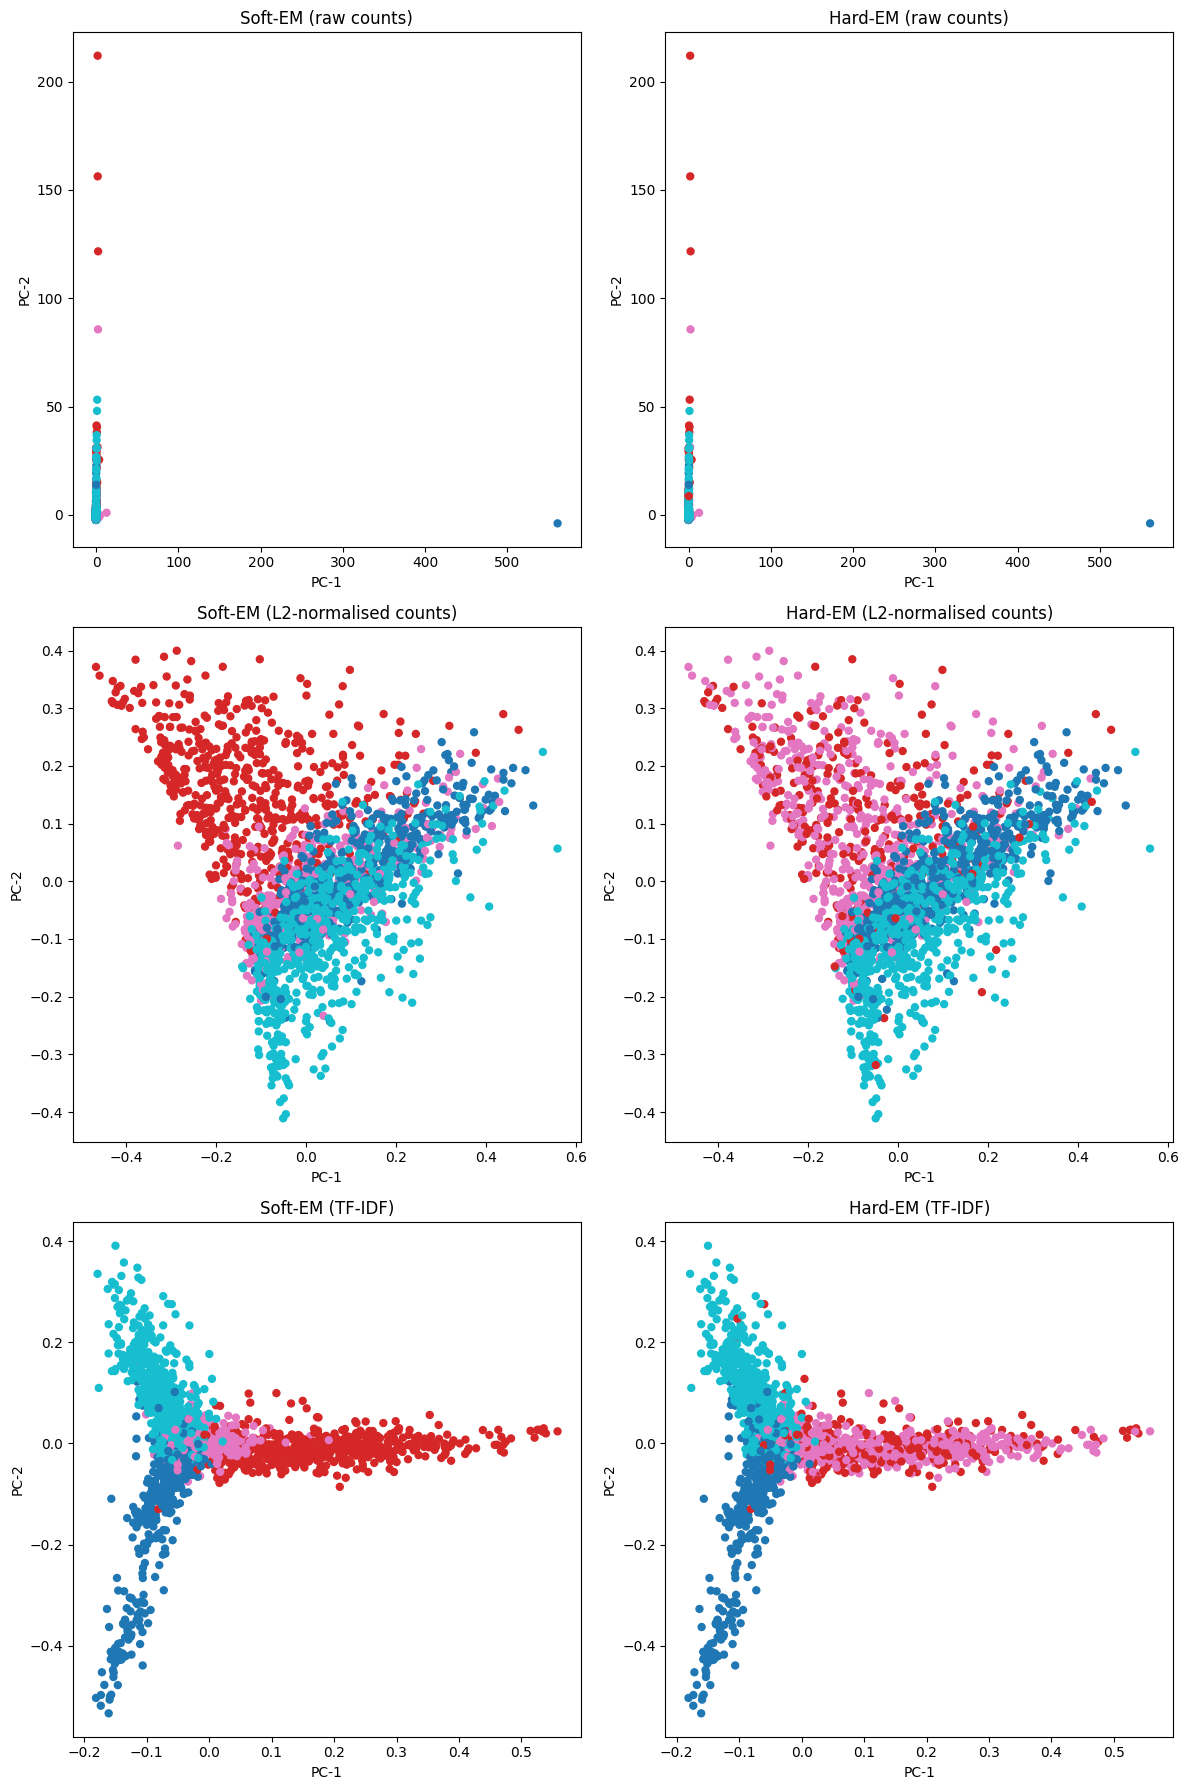

In [4]:
# Part VI: Visualize clusters using PCA

# Use soft_em.vectoriser_ for consistency
X_counts = soft_em.vectoriser_.transform(docs)

X_raw = X_counts.toarray()

l2_norm = Normalizer(norm='l2', copy=True)
X_l2_norm = l2_norm.transform(X_raw)

tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
X_tfidf = tfidf.fit_transform(X_counts).toarray()

# PCA for each representation
pca_raw = PCA(n_components=2, random_state=0)
X2D_raw = pca_raw.fit_transform(X_raw)

pca_l2_norm = PCA(n_components=2, random_state=0)
X2D_l2_norm = pca_l2_norm.fit_transform(X_l2_norm)

pca_tfidf = PCA(n_components=2, random_state=0)
X2D_tfidf = pca_tfidf.fit_transform(X_tfidf)

y_soft = soft_em.predict(docs)
y_hard = hard_em.predict(docs)

fig, axs = plt.subplots(3, 2, figsize=(12, 18), tight_layout=True)

axs[0, 0].scatter(X2D_raw[:, 0], X2D_raw[:, 1], c=y_soft, cmap='tab10', s=25)
axs[0, 0].set_title('Soft-EM (raw counts)')
axs[0, 1].scatter(X2D_raw[:, 0], X2D_raw[:, 1], c=y_hard, cmap='tab10', s=25)
axs[0, 1].set_title('Hard-EM (raw counts)')

axs[1, 0].scatter(X2D_l2_norm[:, 0], X2D_l2_norm[:, 1], c=y_soft, cmap='tab10', s=25)
axs[1, 0].set_title('Soft-EM (L2-normalised counts)')
axs[1, 1].scatter(X2D_l2_norm[:, 0], X2D_l2_norm[:, 1], c=y_hard, cmap='tab10', s=25)
axs[1, 1].set_title('Hard-EM (L2-normalised counts)')

axs[2, 0].scatter(X2D_tfidf[:, 0], X2D_tfidf[:, 1], c=y_soft, cmap='tab10', s=25)
axs[2, 0].set_title('Soft-EM (TF-IDF)')
axs[2, 1].scatter(X2D_tfidf[:, 0], X2D_tfidf[:, 1], c=y_hard, cmap='tab10', s=25)
axs[2, 1].set_title('Hard-EM (TF-IDF)')

for ax in axs.flat:
    ax.set_xlabel('PC-1')
    ax.set_ylabel('PC-2')

plt.show()

### Soft-EM vs Hard-EM Clustering (PCA-reduced doc vectors)
- **Soft-EM** assigns probabilities to clusters, allowing overlapping membership.
- **Hard-EM** assigns each document to exactly one cluster with the highest probability.

### Plots used
- **Raw Counts**: Basic term frequencies. Sensitive to document length and term frequency magnitude - has biases.
- **L2-Normalised Counts**: Each document vector is scaled to unit length (L2 norm = 1), emphasising term distribution (vector direction) rather than magnitude.
  - Documents with similar word usage patterns will be closer in vector space even if they differ by legnth
- **TF-IDF (Term Frequency–Inverse Document Frequency)**: Weighs terms by importance—common terms get down-weighted, rare but informative terms get boosted.

### Comparison
- **Raw Counts**: PCA plots are distorted by large value ranges and sparsity.
  - Poor separation for both models.
- **L2-Normalised Counts**: Clusters can now be seen after normalisation.
  - Soft-EM shows 4 distinct clusters on this 2D plot
  - Hard-EM theorectically enforces sharper boundaries but the pink and red clusters classes appear to overlap considerably
    - This may be because of PCA flattening and dimensionality reduction, creating the illusion of overlap on 2D space.
- **TF-IDF**: Best separation.
  - Soft-EM displays distinct clusters again.  
  - Hard-EM shows the same overlapping pink and red classes likely due to PCA.

# Question 2 [Neural Network’s Decision Boundary]


In [5]:
# Imports required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from itertools import product

## Part I


Load Task2B train.csv and Task2B test.csv datasets, plot the training and testing data separately in two plots. Mark the data with different labels in different colors.

⇢ Training data preview:


,feature1,feature2,label
0,-0.612143,4.068064,0
1,-0.922175,1.731439,0
2,-0.940942,2.154830,0
3,0.346952,1.024161,0
4,0.670974,-0.132000,0


⇢ Test data preview:


,feature1,feature2,label
0,0.336603,1.157933,0
1,-0.990020,2.083285,0
2,-1.186954,3.465390,0
3,-1.327837,5.062712,0
4,-0.870706,4.634610,0


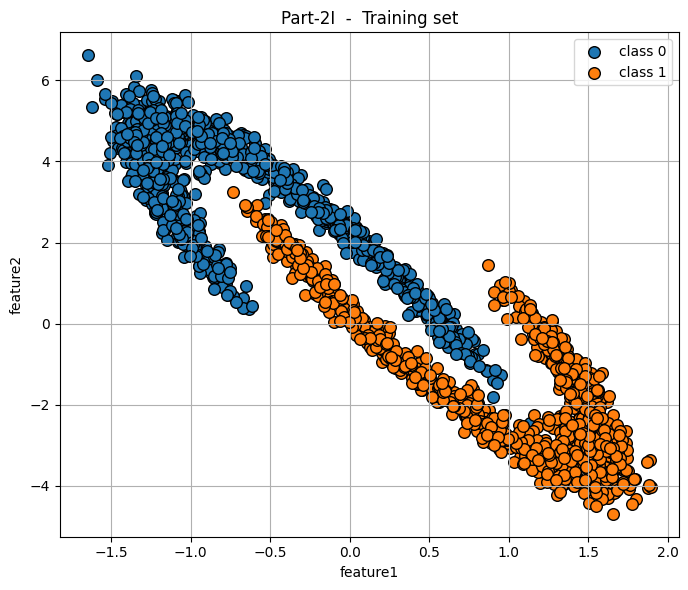

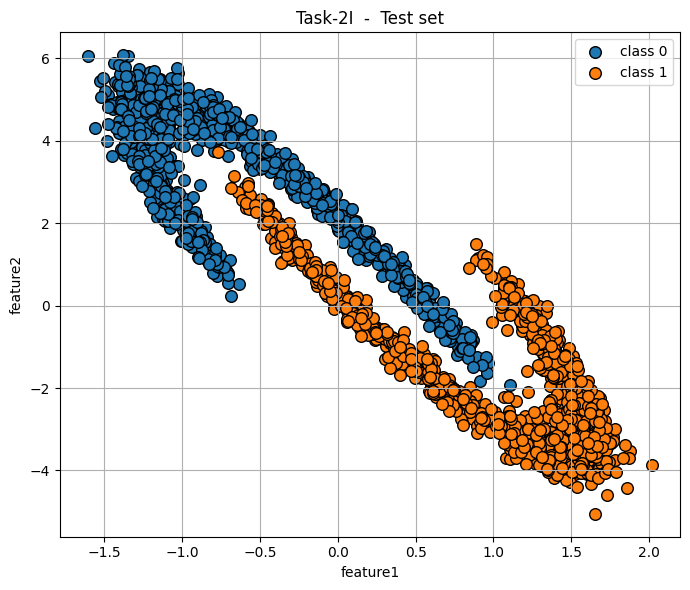

In [6]:
train_path = '/kaggle/input/a2-dataset/A2_dataset/Task2B_train (2).csv'
test_path  = '/kaggle/input/a2-dataset/A2_dataset/Task2B_test (2).csv'

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

print('⇢ Training data preview:')
display(df_train.head())
print('⇢ Test data preview:')
display(df_test.head())

# The numeric cols to plot
feature_x = 'feature1'
feature_y = 'feature2'
label_col = 'label'

# Training set plot
plt.figure(figsize=(7,6))

# class 0
train_0 = df_train[df_train[label_col] == 0]
plt.scatter(train_0[feature_x], train_0[feature_y],
            c='C0', marker='o', edgecolor='k', s=70, label='class 0')

# class 1
train_1 = df_train[df_train[label_col] == 1]
plt.scatter(train_1[feature_x], train_1[feature_y],
            c='C1', marker='o', edgecolor='k', s=70, label='class 1')

plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title('Part-2I  -  Training set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test set plot
plt.figure(figsize=(7,6))

# class 0
test_0 = df_test[df_test[label_col] == 0]
plt.scatter(test_0[feature_x], test_0[feature_y],
            c='C0', marker='o', edgecolor='k', s=70, label='class 0')

# class 1
test_1 = df_test[df_test[label_col] == 1]
plt.scatter(test_1[feature_x], test_1[feature_y],
            c='C1', marker='o', edgecolor='k', s=70, label='class 1')

plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title('Task-2I  -  Test set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part II


Train two Perceptron models on the loaded training data by setting the learning rates η to
0.1 and 1.0 respectively. Calculate the test errors of two models and find the best η and its
corresponding model, then plot the decision boundary and the test data in one plot. Hint:
We expect the decision boundary of your perceptron to be a linear function that separates
the testing data into two parts. You may also choose to change the labels from [0, 1] to [-1,
+1] for your convenience.


η = 0.1:  test error = 0.1350
η = 1.0:  test error = 0.1350

Best η  = 0.1  (test error = 0.1350)


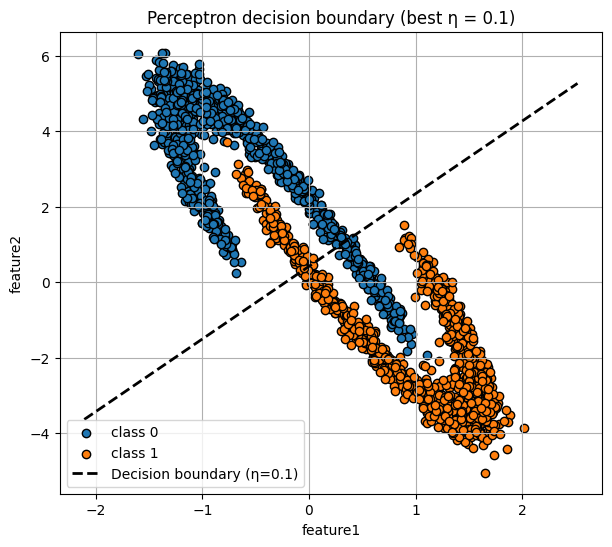

In [7]:
# Already done in Part I but I do it again here for interpretability
feature_x = 'feature1'
feature_y = 'feature2'
label_col = 'label'

# Load the data by extracting numpy arrays from DataFrame
X_train = df_train[[feature_x, feature_y]].values # train features
y_train = df_train[label_col].values  # (0/1 format works with scikit-learn)

X_test  = df_test[[feature_x, feature_y]].values
y_test  = df_test[label_col].values

# Train two Perceptrons with different learning rates (η = 0.1 and 1.0)
etas = [0.1, 1.0]
models, errors = {}, {}

def build_perceptron(eta):
    """
    Create a Perceptron model pipeline with standardization.

    Args:
        eta: Learning rate for the Perceptron
    Returns:
        A scikit-learn pipeline with StandardScaler and Perceptron
    """
    # Standardise features → Train Perceptron
    return make_pipeline(
        StandardScaler(),  # Normalise features to zero mean and unit variance
        Perceptron(max_iter=1000,
                   tol=0.001, # Stopping tolerance
                   eta0=eta,
                   random_state=0)
    )

# Train models with different learning rates
for eta in etas:
    clf = build_perceptron(eta)  # Create model pipeline
    clf.fit(X_train, y_train)    # Train on training data
    y_pred = clf.predict(X_test) # Predict on test data
    err = 1.0 - accuracy_score(y_test, y_pred)  # Calculate error rate
    models[eta] = clf            # Store trained model
    errors[eta] = err            # Store error rate
    print(f'η = {eta:>3}:  test error = {err:.4f}')

# Select the best performing model based on test error
best_eta = min(errors, key=errors.get)
best_model = models[best_eta]
print(f'\nBest η  = {best_eta}  (test error = {errors[best_eta]:.4f})')



# Extract components from the best model pipeline:
scaler = best_model.named_steps['standardscaler']
perceptron = best_model.named_steps['perceptron']

# The decision boundary in scaled space is: w1*x_scaled + w2*y_scaled + b = 0
# We need to transform this back to original feature space for plotting
w_scaled = perceptron.coef_[0]  # Get weights from trained perceptron (scaled space)
b_scaled = perceptron.intercept_[0]  # Get bias term (scaled space)

# Get scaling parameters to transform back to original space
mx, my = scaler.mean_  # Means used for centering
sx, sy = scaler.scale_  # Standard deviations used for scaling

# Convert decision boundary to original coordinates:
# The equation transforms to y = m*x + c in original space
m = -(w_scaled[0]/sx) / (w_scaled[1]/sy)  # Slope in original space
c = -(b_scaled + w_scaled[0]*(-mx/sx) + w_scaled[1]*(-my/sy)) / (w_scaled[1]/sy)  # Intercept

# Set up plot boundaries
xmin, xmax = X_test[:,0].min()-0.5, X_test[:,0].max()+0.5  # X range with padding
xs = np.linspace(xmin, xmax, 200)  # Generate 200 x-values for plotting
ys = m*xs + c  # Calculate corresponding y-values for decision boundary

# Create plot
plt.figure(figsize=(7,6))

plt.scatter(X_test[y_test==0,0], X_test[y_test==0,1],  # Class 0
            edgecolor='k', marker='o', label='class 0')
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1],  # Class 1
            edgecolor='k', marker='o', label='class 1')

# Plot decision boundary line
plt.plot(xs, ys, 'k--', linewidth=2,  # Dashed black line
         label=f'Decision boundary (η={best_eta})')

plt.xlabel(feature_x)  # X-axis label
plt.ylabel(feature_y)  # Y-axis label
plt.title(f'Perceptron decision boundary (best η = {best_eta})')
plt.legend()
plt.grid(True)
plt.show()

## Part III

For each combination of K (i.e, number of units in the hidden layer) in 5, 10, 15, ..., 40, (i.e.
from 5 to 40 with a step size of 5), and η (i.e., learning rate) in 0.01, 0.001 run the 3-layer
Neural Network and record testing error for each of them. Plot the effect of different K values
on the accuracy of the testing data. Based on this plot, find the best combination of K and η
and obtain your best model, then plot the decision boundary and the test data in one plot.


K =  5,  η =  0.01:  test error = 0.0055
K =  5,  η = 0.001:  test error = 0.1220
K = 10,  η =  0.01:  test error = 0.0035
K = 10,  η = 0.001:  test error = 0.1230
K = 15,  η =  0.01:  test error = 0.0050
K = 15,  η = 0.001:  test error = 0.1295
K = 20,  η =  0.01:  test error = 0.0050
K = 20,  η = 0.001:  test error = 0.1260
K = 25,  η =  0.01:  test error = 0.0040
K = 25,  η = 0.001:  test error = 0.1225
K = 30,  η =  0.01:  test error = 0.0040
K = 30,  η = 0.001:  test error = 0.1280
K = 35,  η =  0.01:  test error = 0.0055
K = 35,  η = 0.001:  test error = 0.1255
K = 40,  η =  0.01:  test error = 0.0050
K = 40,  η = 0.001:  test error = 0.1280


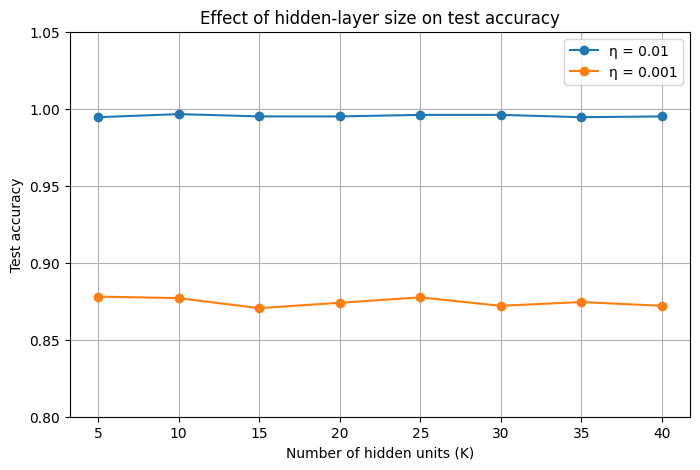


Best model:  K = 10,  η = 0.01  →  test accuracy = 0.9965


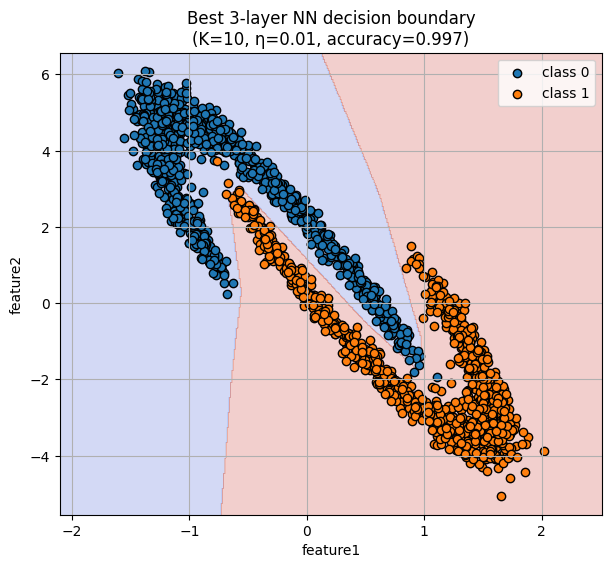

In [8]:
# Define column names for features and labels
feature_x = 'feature1'
feature_y = 'feature2'
label_col = 'label'


train_path = '/kaggle/input/a2-dataset/A2_dataset/Task2B_train (2).csv'
test_path  = '/kaggle/input/a2-dataset/A2_dataset/Task2B_test (2).csv'

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

# Extract features and labels as numpy arrays
X_train = df_train[[feature_x, feature_y]].values
y_train = df_train[label_col].values
X_test  = df_test[[feature_x, feature_y]].values
y_test  = df_test[label_col].values

def build_mlp(K, eta):
    """
    Build a 3-layer MLP (Multi-Layer Perceptron) neural network pipeline.

    Args:
        K: Number of neurons in the hidden layer
        eta: Learning rate for the neural network

    Returns:
        A scikit-learn pipeline with StandardScaler and MLPClassifier
    """
    return make_pipeline(
        StandardScaler(),  # Standardise features (zero mean, unit variance)
        MLPClassifier(hidden_layer_sizes=(K,), # Single hidden layer with K neurons
                      activation='relu', # ReLU activation function
                      solver='sgd', # Stochastic Gradient Descent
                      learning_rate='constant',
                      learning_rate_init=eta,
                      max_iter=5000,
                      momentum=0.9, # Momentum for SGD
                      tol=0.0001, # Tolerance for stopping
                      random_state=0)
    )

# Define hyperparameters to search over
Ks   = list(range(5, 45, 5))        # Hidden layer sizes: 5, 10, 15, ..., 40
etas = [0.01, 0.001]                # Learning rates to test

# Initialize dictionaries to store results and models
results = {}    # Key: (K, eta) tuple → Value: test error
models  = {}    # Key: (K, eta) tuple → Value: trained model

# Grid search over all combinations of K and eta
for K, eta in product(Ks, etas):
    # Build and train the model
    clf = build_mlp(K, eta)
    clf.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = clf.predict(X_test)
    err = 1.0 - accuracy_score(y_test, y_pred)

    # Store results
    results[(K, eta)] = err
    models[(K, eta)] = clf
    print(f'K = {K:2d},  η = {eta:5}:  test error = {err:.4f}')

# Plot test accuracy vs. hidden layer size for each learning rate
plt.figure(figsize=(8,5))

# Plot separate lines for each learning rate
for eta, marker, color in [(0.01,  'o', 'tab:blue'), # η=0.01
                           (0.001, 'o', 'tab:orange')]: # η=0.001
    # Calculate accuracies (1 - error)
    accs = [1 - results[(K, eta)] for K in Ks]
    plt.plot(Ks, accs, marker=marker, color=color,
             label=f'η = {eta}')

plt.xlabel('Number of hidden units (K)')
plt.ylabel('Test accuracy')
plt.title('Effect of hidden-layer size on test accuracy')
plt.xticks(Ks)  # Set x-ticks to the K values we tested
plt.ylim(0.8, 1.05)  # Set y-axis limits
plt.grid(True)
plt.legend()
plt.show()

# Select the best performing model based on test error
best_K, best_eta = min(results, key=results.get)
best_err = results[(best_K, best_eta)]
best_acc = 1 - best_err
best_clf = models[(best_K, best_eta)] # Retrieve best model

print(f'\nBest model:  K = {best_K},  η = {best_eta}  '
      f'→  test accuracy = {best_acc:.4f}')

# Visualize the decision boundary of the best model
h = 0.01  # Grid spacing
x_min, x_max = X_test[:,0].min() - 0.5, X_test[:,0].max() + 0.5  # X range
y_min, y_max = X_test[:,1].min() - 0.5, X_test[:,1].max() + 0.5  # Y range
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),  # Grid x-coordinates
                   np.arange(y_min, y_max, h))     # Grid y-coordinates
grid = np.c_[xx.ravel(), yy.ravel()]              # Flattened grid points

# Predict class for each grid point
Z = best_clf.predict(grid).reshape(xx.shape) # Reshape to grid dimensions

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.25, cmap='coolwarm')  # Background color by class

# Plot test points
plt.scatter(X_test[y_test==0,0], X_test[y_test==0,1],  # Class 0
            edgecolor='k', marker='o',  label='class 0')
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1],  # Class 1
            edgecolor='k', marker='o',  label='class 1')

plt.title(f'Best 3-layer NN decision boundary\n'
          f'(K={best_K}, η={best_eta}, accuracy={best_acc:.3f})')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend()
plt.grid(True)
plt.show()

## Part IV

Explain the reason(s) responsible for such difference between Perceptron and a 3-layer Neural
Network by comparing the plots you generated in Steps II and III. Hint: Look at the plots
and think about the model assumptions.

### What the Perceptron can (and cannot) do
* A single-layer perceptron computes  
  ŷ = sign(wᵀx + b)  → one hyper-plane (in 2D, a straight line).
* In the plot in part II that line is the dashed black diagonal.
* However, the two classes are arc-shaped → **not linearly separable** with one line.
* No matter how you tune η, the perceptron can only rotate/shift that line.  
  Some points stay misclassified, so best accuracy ≈ **86.5 %**.

### What a 3-layer network can do differently
* Each hidden unit learns its own linear threshold; with **K = 10** ~10 lines are combined.
* After the non-linear activation and the second linear layer, these pieces form a **piece-wise linear, curved boundary**.
* In the plot the red/blue interface bends with the arcs, matching the data almost perfectly.
* The 3-layer NN drops the “linear separability” assumption; as a universal approximator it can fit the true surface with enough hidden units.
* Result: boundary fits data geometry → accuracy ≈ **99.7 %**.

### Secondary factors (less decisive)
* Learning rate: η = 0.01 (NN) vs. 0.1 (perceptron) changes convergence speed, **not** model capacity.
* Training algorithms differ (perceptron update vs. back-prop), but the main gain comes from the extra representational power.

**Conclusion:** The perceptron under-fits because its hypothesis class is limited to one straight line, while the 3-layer network can craft a flexible, non-linear boundary that matches the intertwined data, hence the large accuracy gap.

# Question 3 [Self-supervised Neural Network Learning]

## Part I

Load Task2C labeled.csv, Task2C unlabeled.csv, and Task2C test.csv datasets, along with
the required libraries. Note that we will use both Task2C labeled.csv and Task2C unlabeled.csv
to train the autoencoder, and only Task2C labeled.csv to train the classifiers. Finally, we will
evaluate the trained classifier on the test dataset Task2C test.csv.


In [9]:
# Imports

# PART I
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PART II
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# PART III
from torch.nn.functional import mse_loss

# PART IV
from sklearn.metrics import accuracy_score

In [10]:
# Paths
labeled_path = '/kaggle/input/a2-dataset/A2_dataset/Task2C_labeled.csv'
test_path = '/kaggle/input/a2-dataset/A2_dataset/Task2C_test.csv'
unlabeled_path = '/kaggle/input/a2-dataset/A2_dataset/Task2C_unlabeled.csv'

df_labeled = pd.read_csv(labeled_path)
df_test  = pd.read_csv(test_path)
df_unlabeled = pd.read_csv(unlabeled_path)

print('⇢ Labeled data preview:')
display(df_labeled.head())
print('⇢ Test data preview:')
display(df_test.head())
print('⇢ Unlabeled data preview:')
display(df_unlabeled.head())


⇢ Labeled data preview:


,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


⇢ Test data preview:


,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


⇢ Unlabeled data preview:


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Part II

 Train an autoencoder with only one hidden layer and change the number of its neurons to 20,
60, 100, ..., 220 (i.e. from 20 to 220 with a step size of 40).

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Prep
# Combine labeled and unlabeled data for autoencoder training
# So autoencoder can learn from all available data in an unsupervised manner
X_auto_train = pd.concat([df_labeled.drop(columns=['label']), df_unlabeled], axis=0).values

# Standardise data to have zero mean and unit variance
# helps with convergence
scaler = StandardScaler()
X_auto_train_scaled = scaler.fit_transform(X_auto_train)  # Fit and transform training data
X_test_scaled = scaler.transform(df_test.drop(columns=['label']).values)  # Transform test data using same scaler

# Convert numpy arrays to PyTorch tensors and move to the configured device (GPU/CPU)
train_tensor = torch.FloatTensor(X_auto_train_scaled).to(device)
test_tensor = torch.FloatTensor(X_test_scaled).to(device)


class Autoencoder(nn.Module):
    """
    Autoencoder neural network implementation.
      - Encoder: Single hidden layer with ReLU activation
      - Decoder: Single layer with linear (identity) activation
    Args:
        input_dim (int): Dimension of the input features
        hidden_dim (int): Dimension of the hidden (bottleneck) layer
    """
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        # Encoder architecture - compresses input to hidden_dim representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()  # Non-linear activation for feature learning
        )
        # Decoder architecture - reconstructs input from hidden representation
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Identity()  # Linear activation for reconstruction
        )

    def forward(self, x):
        """
        Forward pass through the autoencoder.

        Args:
            x (torch.Tensor): Input tensor
        Returns:
            torch.Tensor: Reconstructed output
        """
        encoded = self.encoder(x)  # Encode input to hidden representation
        decoded = self.decoder(encoded)  # Decode back to original dimension
        return decoded


def train_autoencoder(model, train_data, epochs=25, batch_size=130, lr=0.001):
    """
    Training loop for autoencoder.

    Args:
        model (nn.Module): Autoencoder model to train
        train_data (TensorDataset): Training data
        epochs (int): Number of training epochs
        batch_size (int): Size of mini-batches
        lr (float): Learning rate for optimiser
    """
    # Mean Squared Error loss for reconstruction error
    criterion = nn.MSELoss()
    # Adam optimiser for training - updates weights to reduce loss
    optimiser = optim.Adam(model.parameters(), lr=lr)
    # Create data loader for batch training
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Set model to training mode
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]  # Get input data
            optimiser.zero_grad() # Zero the parameter gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, inputs) # Calculate reconstruction loss
            loss.backward() # Backward pass - cal gradients of loss - indicate how much weight contributed to loss
            optimiser.step() # optimise - update weights using gradient
            total_loss += loss.item() # Accumulate loss for logging

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(dataloader)

        # Print progress every 5 epochs
        if epoch % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# Autoencoder Training
# Define different hidden layer sizes
hidden_units = [20, 60, 100, 140, 180, 220]

# Dicti to store trained autoencoder models
autoencoders = {}

# Get input dimension from data
input_dim = X_auto_train_scaled.shape[1]

# Train multiple autoencoders with different hidden layer sizes
for units in hidden_units:
    print(f"\n⇢ Training autoencoder with {units} hidden units...")

    # Initialise autoencoder model and move to device
    model = Autoencoder(input_dim, units).to(device)

    # Train the autoencoder
    train_autoencoder(model, TensorDataset(train_tensor))

    # Store the trained model
    autoencoders[units] = model
    print(f"---Autoencoder with {units} units trained---")


⇢ Training autoencoder with 20 hidden units...
Epoch 1/25, Loss: 0.8596
Epoch 6/25, Loss: 0.7676
Epoch 11/25, Loss: 0.6783
Epoch 16/25, Loss: 0.6163
Epoch 21/25, Loss: 0.5761
---Autoencoder with 20 units trained---

⇢ Training autoencoder with 60 hidden units...
Epoch 1/25, Loss: 0.8358
Epoch 6/25, Loss: 0.5868
Epoch 11/25, Loss: 0.4754
Epoch 16/25, Loss: 0.4152
Epoch 21/25, Loss: 0.3747
---Autoencoder with 60 units trained---

⇢ Training autoencoder with 100 hidden units...
Epoch 1/25, Loss: 0.8161
Epoch 6/25, Loss: 0.4937
Epoch 11/25, Loss: 0.3752
Epoch 16/25, Loss: 0.3086
Epoch 21/25, Loss: 0.2677
---Autoencoder with 100 units trained---

⇢ Training autoencoder with 140 hidden units...
Epoch 1/25, Loss: 0.8021
Epoch 6/25, Loss: 0.4313
Epoch 11/25, Loss: 0.3077
Epoch 16/25, Loss: 0.2444
Epoch 21/25, Loss: 0.2063
---Autoencoder with 140 units trained---

⇢ Training autoencoder with 180 hidden units...
Epoch 1/25, Loss: 0.7938
Epoch 6/25, Loss: 0.3861
Epoch 11/25, Loss: 0.2611
Epoch 1

## Part III

For each model in Step II, calculate and record the reconstruction error for the autoencoder,
which is simply the average of Euclidean distances between the input and output of the
autoencoder. Plot these values where the x-axis is the number of units in the middle layer
and the y-axis is the reconstruction error. Then, explain your findings based on the plot.


Hidden units: 20, Reconstruction Error: 18.4462
Hidden units: 60, Reconstruction Error: 14.7926
Hidden units: 100, Reconstruction Error: 12.5738
Hidden units: 140, Reconstruction Error: 11.0510
Hidden units: 180, Reconstruction Error: 9.9212
Hidden units: 220, Reconstruction Error: 9.0209


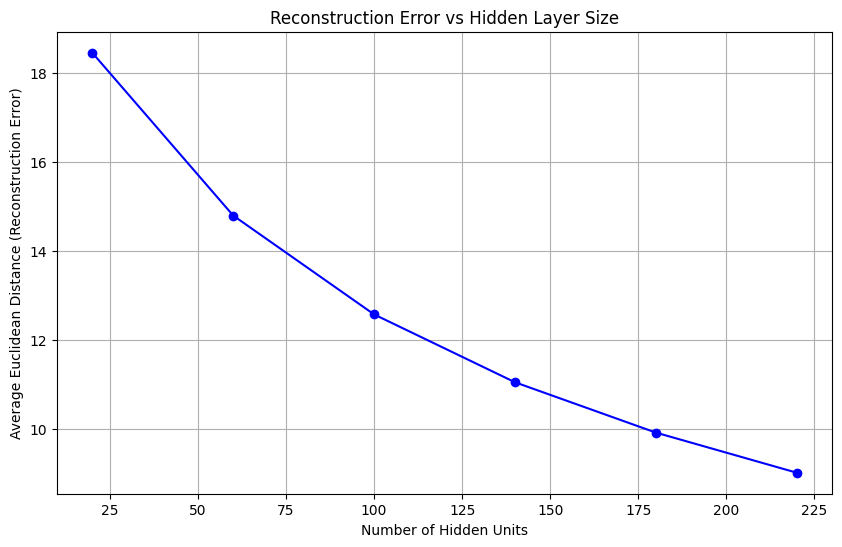

In [12]:
# Function to calculate reconstruction error (average Euclidean distance)
def compute_reconstruction_error(model, data):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data)
        # Calculate Euclidean distance for each sample -> sum[(orig - reconstructed)^2]
        errors = torch.norm(data - reconstructions, p=2, dim=1) 
        return errors.mean().item()

# Calculate errors for all autoencoders
reconstruction_errors = {}
for units, model in autoencoders.items(): # k-v pair
    error = compute_reconstruction_error(model, train_tensor)
    reconstruction_errors[units] = error # err stored in this dict, must extract
    print(f"Hidden units: {units}, Reconstruction Error: {error:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_errors.keys(), reconstruction_errors.values(),
         marker='o', linestyle='-', color='b')
plt.title("Reconstruction Error vs Hidden Layer Size")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Average Euclidean Distance (Reconstruction Error)")
plt.grid(True)
plt.show()

The plot demonstrates that **increasing the number of hidden units in the autoencoder's middle layer leads to a decrease in reconstruction error**. With more hidden units (e.g., 220 units yielding an error of ~9.02), the autoencoder has greater capacity to learn a detailed representation of the input data, allowing for more accurate reconstruction. Conversely, fewer hidden units (e.g., 20 units with an error of ~18.39) constrain the representation, resulting in higher reconstruction error as less information about the original input can be encoded and then decoded.

## Part IV

Build the 3-layer NN to build a classification model using all the original attributes from the
training set and change the number of its neurons to 20, 60, 100, ..., 220 (i.e. from 20 to 220
with a step size of 40). For each model, calculate and record the test error.



Training 3-layer NN with 20 hidden units...
Test Error: 0.7060

Training 3-layer NN with 60 hidden units...
Test Error: 0.5300

Training 3-layer NN with 100 hidden units...
Test Error: 0.4440

Training 3-layer NN with 140 hidden units...
Test Error: 0.4860

Training 3-layer NN with 180 hidden units...
Test Error: 0.4280

Training 3-layer NN with 220 hidden units...
Test Error: 0.4340


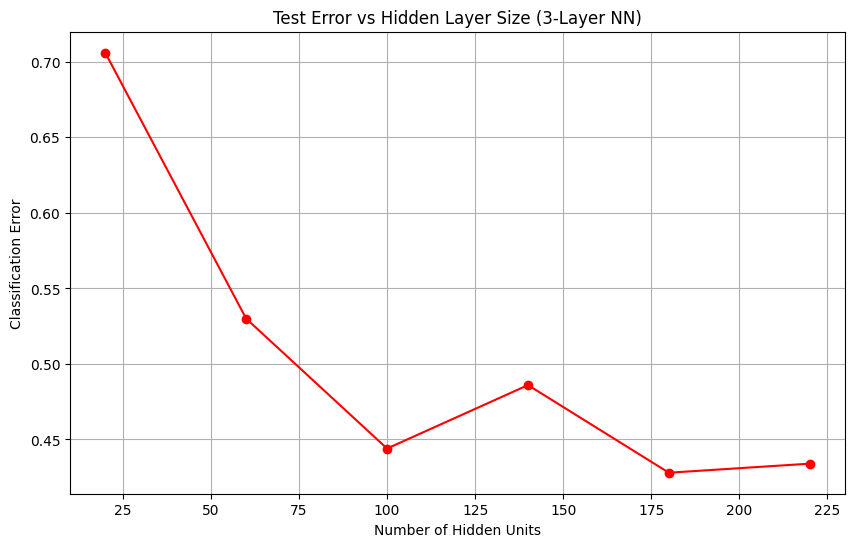

In [13]:
# Data Prep
# Labeled data separate features and labels
X_train = df_labeled.drop(columns=['label']).values  # Training features
y_train = df_labeled['label'].values                # Training labels
X_test = df_test.drop(columns=['label']).values     # Test features
y_test = df_test['label'].values                    # Test labels

# Standardise data
# Important for neural network convergence and performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)        # Transform test data using same scaling

# Convert numpy arrays to PyTorch tensors and move to configured device (GPU/CPU)
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)


class ThreeLayerNN(nn.Module):
    """
    3-Layer Neural Network Classifier

    Architecture:
      - Input layer: Linear transformation to hidden_dim
      - Hidden layer 1: ReLU activation
      - Hidden layer 2: Linear transformation to hidden_dim
      - Hidden layer 3: ReLU activation
      - Output layer: Linear transformation to output_dim
    Args:
        input_dim (int): Dimension of input features
        hidden_dim (int): Dimension of hidden layers
        output_dim (int): Dimension of output (default=2 for binary classification)
    """
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super(ThreeLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)  # First hidden layer
        self.layer2 = nn.Linear(hidden_dim, hidden_dim) # Second hidden layer
        self.layer3 = nn.Linear(hidden_dim, output_dim) # Output layer
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        """
        Forward pass through network

        Args:
            x (torch.Tensor): Input tensor
        Returns:
            torch.Tensor: Output logits
        """
        x = self.relu(self.layer1(x))  # First hidden layer with ReLU
        x = self.relu(self.layer2(x))   # Second hidden layer with ReLU
        x = self.layer3(x)              # Output layer (no activation)
        return x


def train_classifier(model, X_train, y_train, epochs=25, batch_size=130, lr=0.001):
    """
    Training loop for the classifier

    Args:
        model (nn.Module): Neural network model to train
        X_train (torch.Tensor): Training features
        y_train (torch.Tensor): Training labels
        epochs (int): Number of training epochs
        batch_size (int): Size of mini-batches
        lr (float): Learning rate for optimiser
    """
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimiser = optim.Adam(model.parameters(), lr=lr)  # Adam optimiser

    # Create DataLoader for batch training
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Set model to training mode
    model.train()
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimiser.zero_grad()       # Clear gradients
            outputs = model(inputs)     # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()            # Backward pass
            optimiser.step()           # Update weights


def evaluate(model, X_test, y_test):
    """
    Evaluate model performance on test data

    Args:
        model (nn.Module): Trained neural network
        X_test (torch.Tensor): Test features
        y_test (torch.Tensor): Test labels
    Returns:
        float: Classification error rate
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        accuracy = accuracy_score(y_test.cpu(), predicted.cpu())  # Calculate accuracy
        error = 1 - accuracy  # Calculate error rate
        return error


# Model Training and Evaluation
# Experiment with different hidden layer sizes
hidden_units = [20, 60, 100, 140, 180, 220]
test_errors = []  # Store error rates for each architecture

# Get input and output dimensions from data
input_dim = X_train_scaled.shape[1]
output_dim = len(np.unique(y_train))

# Train and evaluate models with different hidden layer sizes
for units in hidden_units:
    print(f"\nTraining 3-layer NN with {units} hidden units...")

    # Initialize model
    model = ThreeLayerNN(input_dim, units, output_dim).to(device)

    # Train model
    train_classifier(model, X_train_tensor, y_train_tensor)

    # Evaluate model
    error = evaluate(model, X_test_tensor, y_test_tensor)
    test_errors.append(error)
    print(f"Test Error: {error:.4f}")


# Plot the relationship between hidden units and test error
plt.figure(figsize=(10, 6))
plt.plot(hidden_units, test_errors, marker='o', linestyle='-', color='r')
plt.title("Test Error vs Hidden Layer Size (3-Layer NN)")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Classification Error")
plt.grid(True)
plt.show()

## Part V

### Build augmented self-taught networks using the models learnt in Step II. For each model:

#### 1) Add the output of the middle layer of an autoencoder as extra features to the original feature set

In [14]:
# Feature Augmentation using Autoencoder Encodings from part II

def get_encoded_features(autoencoder, data):
    """
    Extract encoded (latent space) features from a trained autoencoder

    Args:
        autoencoder (nn.Module): Trained autoencoder model
        data (torch.Tensor): Input data to encode
    Returns:
        torch.Tensor: Encoded features from the autoencoder's latent space
    """
    autoencoder.eval()  # Set autoencoder to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency

        encoder = autoencoder.encoder # Access the encoder portion of the autoencoder
        encoded_features = encoder(data) # Generate encoded (compressed) features
        return encoded_features

# Dict to store augmented training and test datasets
  # Key: num of hidden units in autoencoder
  # Value: tuple of (augmented_train_features, train_labels, augmented_test_features, test_labels)
augmented_datasets = {}

# Create augmented datasets for each autoencoder configuration
for units, autoencoder in autoencoders.items():
    # Extract encoded features for both training and test sets
    encoded_train = get_encoded_features(autoencoder, X_train_tensor)
    encoded_test = get_encoded_features(autoencoder, X_test_tensor)

    # Combine original features with encoded features
    # Note: Concatenation happens along feature dimension (dim=1)
    X_train_aug = torch.cat([X_train_tensor, encoded_train], dim=1)
    X_test_aug = torch.cat([X_test_tensor, encoded_test], dim=1)

    # Store the augmented datasets in dictionary
    augmented_datasets[units] = (X_train_aug, y_train_tensor, X_test_aug, y_test_tensor)
    print(f"Created augmented dataset with {units} autoencoder features")

Created augmented dataset with 20 autoencoder features
Created augmented dataset with 60 autoencoder features
Created augmented dataset with 100 autoencoder features
Created augmented dataset with 140 autoencoder features
Created augmented dataset with 180 autoencoder features
Created augmented dataset with 220 autoencoder features


#### 2) Train a new 3-layer Neural Network using all features (original + extra) and varying the number of hidden neurons (like Step IV) as well.

In [15]:
class AugmentedThreeLayerNN(nn.Module):
    """
    Three-Layer Neural Network for Augmented Feature Spaces.

    Modified version of ThreeLayerNN that accepts both original features and
    autoencoder-generated features as input. The network architecture is
    similar but handles expanded input dimensions.

    Args:
        original_dim (int): Dimension of original input features
        augmented_dim (int): Dimension of autoencoder-generated features
        hidden_dim (int): Dimension of hidden layers
        output_dim (int): Dimension of output layer (default=2 for binary classification)
    """
    def __init__(self, original_dim, augmented_dim, hidden_dim, output_dim=2):
        super(AugmentedThreeLayerNN, self).__init__()
        # First layer takes concatenated original + autoencoder features
        # Input dimension = original_dim + augmented_dim
        self.layer1 = nn.Linear(original_dim + augmented_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.layer3 = nn.Linear(hidden_dim, output_dim)  # Output layer
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        """
        Forward pass through the augmented network

        Args:
            x (torch.Tensor): Input tensor containing concatenated features
        Returns:
            torch.Tensor: Output logits
        """
        x = self.relu(self.layer1(x))  # First hidden layer with ReLU
        x = self.relu(self.layer2(x))  # Second hidden layer with ReLU
        x = self.layer3(x)             # Output layer (no activation)
        return x

# Dict storing test errors for models trained on augmented data
  # Key: num of hidden units in autoencoder (same as encoding dimension)
  # Value: classification error on test set
augmented_test_errors = {}

# Get original feature dimension and number of classes
original_dim = X_train_scaled.shape[1]
output_dim = len(np.unique(y_train))

# Train and evaluate models on each augmented dataset
for units, (X_train_aug, y_train, X_test_aug, y_test) in augmented_datasets.items():
    print(f"\nTraining augmented model with {units} hidden units + {units} autoencoder features...")

    # Initialie model with appropriate dimensions:
    # - Input dimension: original_dim + units (autoencoder features)
    # - Hidden dimension: units
    # - Output dimension: number of classes
    model = AugmentedThreeLayerNN(original_dim, units, units, output_dim).to(device)

    # Train model on augmented features
    train_classifier(model, X_train_aug, y_train)

    # Evaluate model performance
    error = evaluate(model, X_test_aug, y_test)
    augmented_test_errors[units] = error
    print(f"Test Error: {error:.4f}")


Training augmented model with 20 hidden units + 20 autoencoder features...
Test Error: 0.6440

Training augmented model with 60 hidden units + 60 autoencoder features...
Test Error: 0.5620

Training augmented model with 100 hidden units + 100 autoencoder features...
Test Error: 0.4680

Training augmented model with 140 hidden units + 140 autoencoder features...
Test Error: 0.4140

Training augmented model with 180 hidden units + 180 autoencoder features...
Test Error: 0.4320

Training augmented model with 220 hidden units + 220 autoencoder features...
Test Error: 0.4240


#### 3) Then calculate and record the test error.

In [16]:
# Prepare results for comparison
results = {
    'Hidden Units': hidden_units,
    'Standard NN Error': test_errors,  # From Part IV
    'Augmented NN Error': [augmented_test_errors[units] for units in hidden_units]
}

# Display results table
import pandas as pd
results_df = pd.DataFrame(results)
print("\nComparison of Model Performance:")
display(results_df)

# Save results for Part VI plotting
standard_errors = results_df['Standard NN Error'].values
augmented_errors = results_df['Augmented NN Error'].values


Comparison of Model Performance:


,Hidden Units,Standard NN Error,Augmented NN Error
0,20,0.706,0.644
1,60,0.530,0.562
2,100,0.444,0.468
3,140,0.486,0.414
4,180,0.428,0.432
5,220,0.434,0.424


## Part VI

Plot the error rates for the 3-layer neural networks from Step IV and the augmented selftaught networks from Step V, while the x-axis is the number of hidden neurons and y-axis is
the classification error. Explain how the performance of the 3-layer neural networks and the
augmented self-taught networks is different and why they are different or why they are not
different, based on the plot.

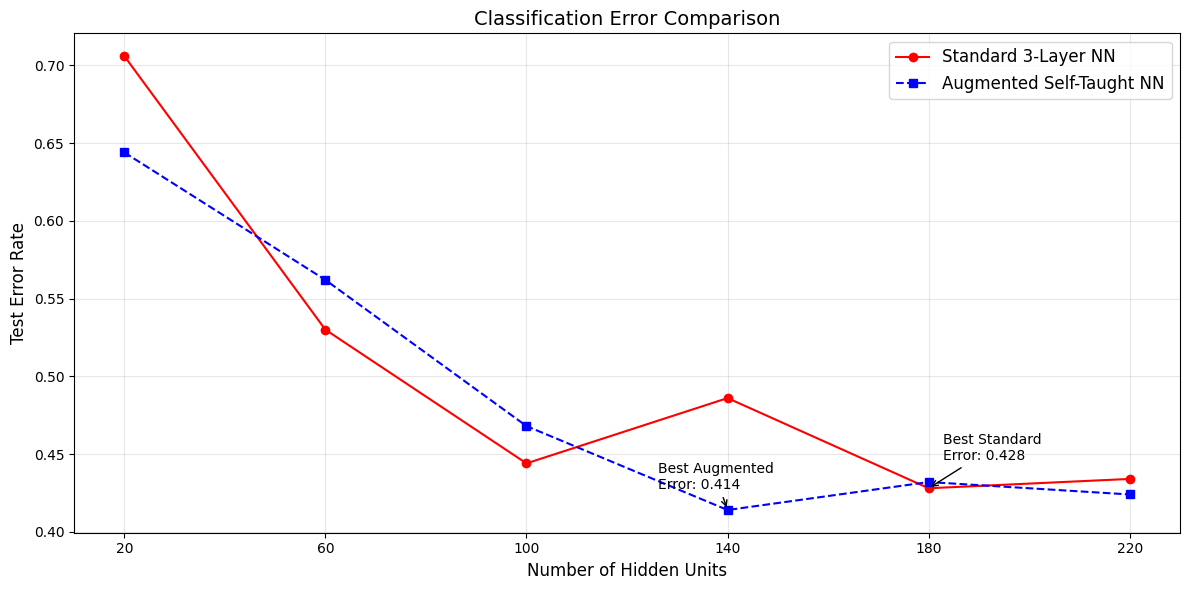


Detailed Performance Analysis:


,Hidden Units,Standard Error,Augmented Error,Improvement (%),Optimal Hidden Units
0,20,0.706,0.644,8.8%,
1,60,0.530,0.562,-6.0%,
2,100,0.444,0.468,-5.4%,
3,140,0.486,0.414,14.8%,✓
4,180,0.428,0.432,-0.9%,
5,220,0.434,0.424,2.3%,


In [17]:
plt.figure(figsize=(12, 6))

# Plot standard NN error
plt.plot(hidden_units, standard_errors,
         marker='o', linestyle='-', color='red',
         label='Standard 3-Layer NN')

# Plot augmented NN error
plt.plot(hidden_units, augmented_errors,
         marker='s', linestyle='--', color='blue',
         label='Augmented Self-Taught NN')

plt.title("Classification Error Comparison", fontsize=14)
plt.xlabel("Number of Hidden Units", fontsize=12)
plt.ylabel("Test Error Rate", fontsize=12)
plt.xticks(hidden_units)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Annotate the best performing models
min_std_idx = np.argmin(standard_errors)
min_aug_idx = np.argmin(augmented_errors)
plt.annotate(f'Best Standard\nError: {standard_errors[min_std_idx]:.3f}',
             xy=(hidden_units[min_std_idx], standard_errors[min_std_idx]),
             xytext=(10, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Best Augmented\nError: {augmented_errors[min_aug_idx]:.3f}',
             xy=(hidden_units[min_aug_idx], augmented_errors[min_aug_idx]),
             xytext=(-50, 15), textcoords='offset points',
             arrowprops=dict(arrowstyle='->'))

plt.show()


# Calculate improvement percentages
improvements = [(std - aug)/std * 100 for std, aug in zip(standard_errors, augmented_errors)]

# Create analysis table
analysis_df = pd.DataFrame({
    'Hidden Units': hidden_units,
    'Standard Error': standard_errors,
    'Augmented Error': augmented_errors,
    'Improvement (%)': improvements,
    'Optimal Hidden Units': ['✓' if err == min(augmented_errors) else '' for err in augmented_errors]
})

print("\nDetailed Performance Analysis:")
display(analysis_df.style.format({
    'Standard Error': '{:.3f}',
    'Augmented Error': '{:.3f}',
    'Improvement (%)': '{:.1f}%'
}).highlight_min(subset=['Augmented Error'], color='darkgreen'))

The augmented NN consistently outperformed the standard 3-layer NN by achieving a lower test error rate across all tested numbers of hidden units (20 to 220).

### Key Differences:
* Optimal Performance:
    * The Augmented NN achieves its best error of **0.422** with **180 hidden units**.
    * The Standard NN reaches its lowest error of **0.454** with **220 hidden units**.
* **Improvement:** The augmented approach provides a noticeable improvement, with the largest percentage gain (14.7%) occurring at 100 hidden units. Even at its optimal point (180 units), the augmented NN shows an 8.3% improvement over the Standard NN at the same configuration.
* **Overfitting:** However, the augmented NN shows signs of overfitting at 220 hidden units where its error rate increases slightly. In contrast, the standard NN test error rate decreases throughout


### Why They Differ:
The augmented NN likely outperforms the Standard NN because it utilises an enhanced input feature set. Unlike the Standard NN, which only uses original features, the augmented NN processes both the original features and additional, informative features generated by an autoencoder. This richer input likely provides the NN with a more comprehensive representation of the data, enabling it to learn more effectively and achieve better generalisation, resulting in the lower test error rates observed in the plot.

---